# Mitigating Income Bias in Access to Diabetes Screenings

#### Trustworthy AI Examples Series

This notebook demonstrates how socioeconomic factors, specifically income, can introduce unfair biases in a diabetes‑risk prediction pipeline. Using the Diabetes dataset, this example scenario simulates a preventive care pipeline that predicts diabetes risk based on health and lifestyle features. Bias mitigation is then performed, targeting underprediction for low-income individuals by applying pre-processing, in-processing, and post-processing fairness techniques, ultimately comparing their performance by measuring selection rate across income level groups to build a more trustworthy prediction system.

While higher screening predictions for low-income individuals may seem beneficial, it can also create inequities in how healthcare resources are distributed and could mask the need for more nuanced, equitable preventive strategies.

Through this scenario, readers will:

1. **Understand the real‑world stakes**: how and why income-based underprediction leads to unequal access to care.
2. **Learn to construct end-to-end AI pipelines**: from data cleaning to bias measurement to mitigation.
3. **Apply fairness strategies in-context**: using residualization + resampling, fairness-constrained optimization, and threshold adjustment to satisfy demographic parity.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

## Imports & Utilities

This notebook will use functions from the `preprocessing.py` file located in the `utils` folder. It is recommended to review the file to gain an understanding of the functions being used before continuing. Click [here](../../python/utils/preprocessing.py) to see the file.

### Fairlearn

**Fairlearn** is a specialized library for evaluating and improving fairness in machine learning models. It is used here for:

#### Fairness Assessment

- `MetricFrame`: computes metrics separately for each group.
- `selection_rate`: measures how often each group receives a positive prediction.

#### Bias Mitigation

- `DemographicParity`: ensures that the rate of positive predictions is the same across all groups defined by a protected attribute, regardless of actual outcomes.
- `ExponentiatedGradient`: an in-processing technique that reweights examples during training to enforce fairness constraints.
- `ThresholdOptimizer`: a post-processing tool that adjusts decision thresholds per group to equalize outcomes after the model has already been trained.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin

from fairlearn.metrics import MetricFrame, selection_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.postprocessing import ThresholdOptimizer

import python.utils.preprocessing as pp

## Data Preparation

In order to train a model on the Diabetes dataset, raw data must be converted into a clean, numeric, and standardized format. After loading the dataset from the CSV file, the first step is to handle any missing values to ensure consistency and avoid errors during model training.

In this case, missing values are imputed using the median of each column, which is a robust strategy that avoids data loss while mitigating the influence of outliers.

In [3]:
file_path = PROJECT_ROOT / 'data/diabetes_binary_full.csv'
df = pp.load_data(file_path)
df = pp.handle_missing_values(df, strategy='median')

display(df.describe())
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.346294,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


### Feature Transformation

To prepare the dataset for modeling, first transform categorical variables using one-hot encoding, excluding the target and sensitive attributes to preserve their interpretability. Next, apply standardization to the numerical features to ensure they are on a comparable scale, which is crucial for many machine learning algorithms.

It is recommended to avoid altering the target variable, `Diabetes_binary`, and sensitive attribute, `Income`, as as modifying these can obscure group-level disparities and make fairness evaluation more difficult.

In [4]:
target_col = 'Diabetes_binary'
sensitive_col = 'Income'

df_enc = pp.encode_categorical_data(df, method='onehot', exclude_cols=[target_col, sensitive_col])
df_scaled = pp.scale_features(df_enc, method='standardize', exclude_cols=[target_col, sensitive_col])

X = df_scaled.drop(columns=[target_col])
y = df_scaled[target_col]
g = df_scaled[sensitive_col]

stratify_labels = df_scaled[target_col].astype(str) + '_' + df_scaled[sensitive_col].astype(str)

X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(X, y, g, test_size=0.2, random_state=42, stratify=stratify_labels)

### Correlation Analysis & Proxy Feature Flagging

After preprocessing, a correlation analysis is performed to understand relationships between features and identify potential proxy features. Proxy features are features that may indirectly encode sensitive information. In the example below, one can see that `Education`, `GenHlth`, and `DiffWalk` have the highest correlation to `Income`, with correlations of 0.45, -0.37, and -0.32 respectively. This gives reason to suspect that they may introduce indirect bias by allowing the model to infer `Income`.

Additionally, the correlation matrix shows a significant number of features with non-negligible correlations, suggesting that proxy debiasing alone may not be enough to address imbalances within the dataset directly.

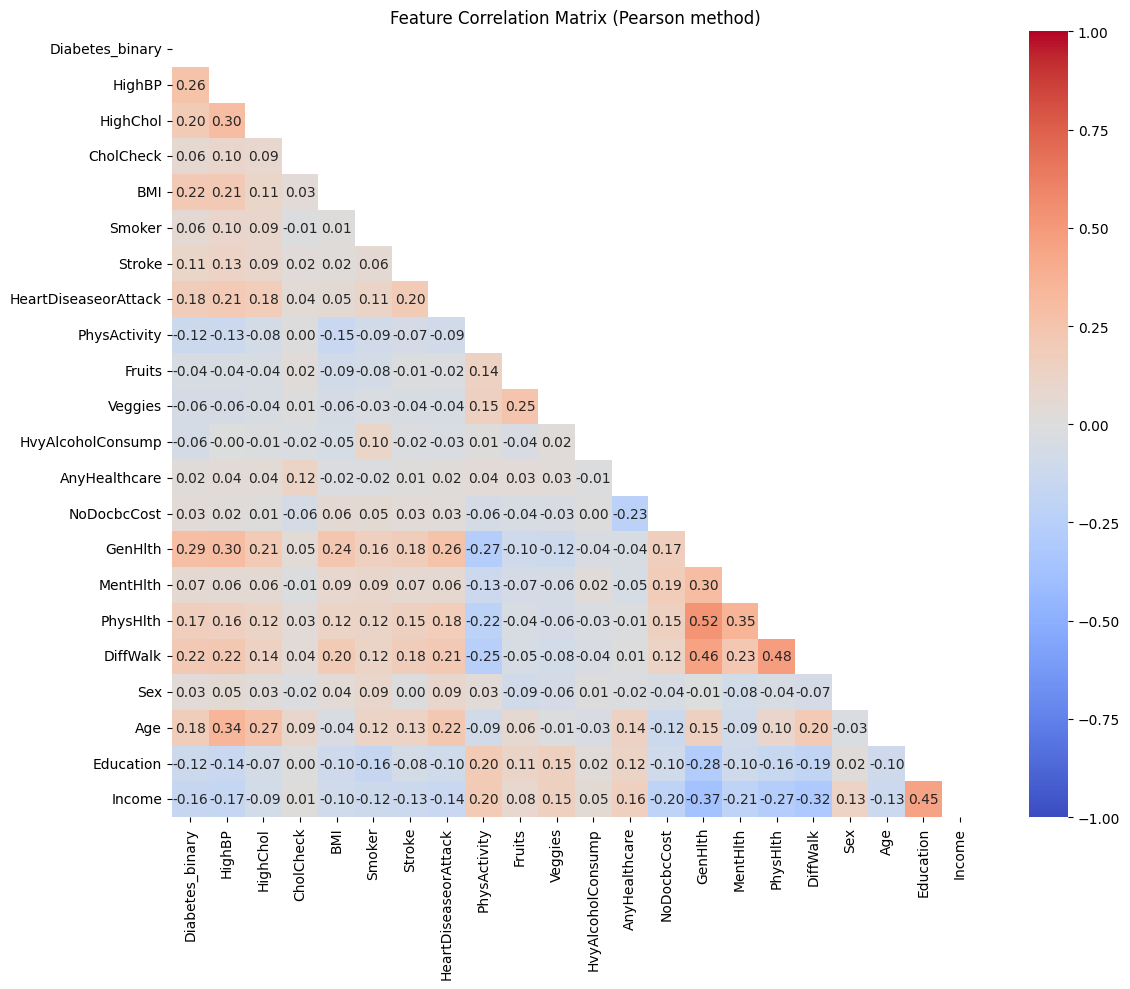

Identified proxy features: {'Income': ['Education', 'GenHlth', 'DiffWalk']}


In [5]:
pp.correlation_matrix(df)
proxy_dict = pp.identify_proxy_variables(df, sensitive_attrs=[sensitive_col], method='relative')
print("Identified proxy features:", proxy_dict)

### Proxy Feature Plots

After identifying potential proxy feature, their correlation to the sensitive variable, `Income`, will be verified. An examination of the distributions for `Education`, `GenHlth` and `DiffWalk` reveals that they are skewed and may encode information related to `Income`. More specifically, individuals with higher incomes (e.g. `Income=7`) show higher education levels, better general health, and less difficulty walking. This creates the risk that predictions reflect structural inequities in the dataset, rather than just health.

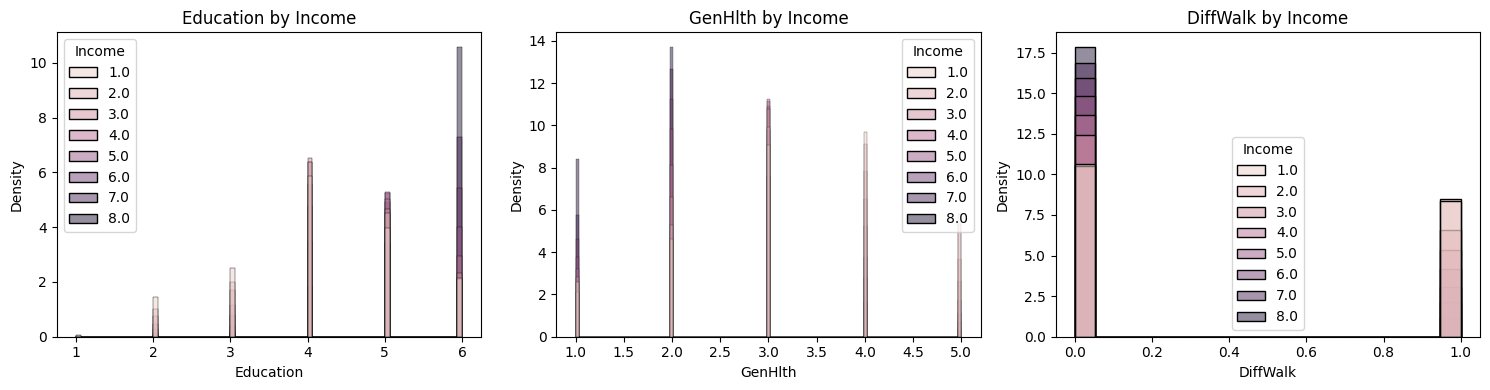

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, col in zip(axes, ['Education', 'GenHlth', 'DiffWalk']):
    sns.histplot(data=df, x=col, hue=sensitive_col, kde=False, ax=ax, stat="density", common_norm=False)
    ax.set_title(f"{col} by {sensitive_col}")

plt.tight_layout(); plt.show()

### Proxy Modeling

Proxy modeling involves training a predictive model to determine whether certain features can be used to infer a sensitive attribute. If the model achieves high accuracy and ROC-AUC, it suggests that these features encode information about the sensitive attribute, even if indirectly.

`Education` is a well-known proxy feature of `Income` and should not provide insight into diabetes diagnosis. As such, it can be removed entirely from the dataset without significant impact on model performance.

Proxy modeling is a strong indicator of potential bias. In this scenario, a logistic regression model is used to predict `Income` with only `GenHlth` and `DiffWalk`. Since `Income` is an ordinal variable on a scale from 1 to 8, random guessing would yield an expected accuracy of ~12.5% and AUC of ~0.5. The model achieved an accuracy of 36.3% and AUC of 0.637, indicating that these features carry significant information about the sensitive attribute and can act as proxy features.

From a practical standpoint, general health status (`GenHlth`) may correlate with income level because individuals with lower incomes often face reduced access to healthcare, nutritious food, and preventive services. Similarly, difficulty walking (`DiffWalk`) is often more prevalent in lower-income populations due to higher rates of physically demanding jobs, limited access to rehabilitative care, and delayed treatment of mobility-related conditions.

Almost all features in the dataset tend to show a non-negligible correlation with `Income`. Many lifestyle, health, and demographic variables are intertwined with socioeconomic status. For instance, variables like exercise frequency, diet quality, chronic condition prevalence, and even self-reported general health often vary systematically across income levels. This pervasive correlation implies that simply removing a few proxy features is unlikely to eliminate all indirect leakage of sensitive information.

In [7]:
remove_features = ['Education']
proxy_features = ['GenHlth', 'DiffWalk']

df_proxy =  df[proxy_features + [sensitive_col]]

X_proxy = df_proxy[proxy_features]
y_proxy = df_proxy[sensitive_col]
X_train_proxy, X_test_proxy, y_train_proxy, y_test_proxy = train_test_split(X_proxy, y_proxy, test_size=0.2, random_state=42)

proxy_model = LogisticRegression(max_iter=1000, random_state=42)
proxy_model.fit(X_train_proxy, y_train_proxy)

y_pred_proxy = proxy_model.predict(X_test_proxy)
y_pred_proba = proxy_model.predict_proba(X_test_proxy)
print(f"Proxy Model Accuracy: {accuracy_score(y_test_proxy, y_pred_proxy):.3f}")
print(f"Proxy Model AUC: {roc_auc_score(y_test_proxy, y_pred_proba, multi_class='ovr'):.3f}")

Proxy Model Accuracy: 0.363
Proxy Model AUC: 0.637


## Baseline Model

To establish a performance benchmark, it is recommended to train a baseline logistic regression model using all features, including sensitive attribute `Income` and proxy features `Education`, `GenHlth` and `DiffWalk`. This model serves as a reference point for evaluating the impact of fairness interventions and feature selection strategies later in the pipeline.

In [8]:
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### Baseline Accuracy Evaluation

After training the baseline logistic regression model, its performance is evaluated using accuracy and ROC AUC. Accuracy measures the proportion of correct predictions, while ROC AUC reflects the model's ability to distinguish between classes across different thresholds.

The baseline model achieves a high overall accuracy (86.5%) and great ROC AUC (0.825), indicating sufficient model performance.

In [9]:
y_pred = baseline_model.predict(X_test)
y_probs = baseline_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_probs)

print("=== Baseline Model ===")
print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {auc:.3f}")

=== Baseline Model ===
Accuracy: 0.865
ROC AUC: 0.825


### Baseline Fairness Evaluation

To assess fairness in the baseline model, the selection rate across groups defined by the sensitive attribute `Income` is examined. In this context, selection rate refers to the proportion of individuals predicted as high-risk for diabetes, which would make them eligible for further screening or intervention. Using `MetricFrame`, selection rates are computed separately for each group to visualize the disparity.

This result reveals a significant disparity: individuals in lower-income brackets are selected for diabetes risk at significantly high rates compared to those in higher-income groups. As income level decreases, the model becomes increasingly likely to flag individuals as high-risk. While this may partially reflect real-world trends, such as higher undiagnosed diabetes rates in low-income populations, it also raises concerns about the model’s potential overreliance on income level as a predictive signal. This risks encoding structural inequalities into the prediction pipeline, potentially leading to over-screening or unfair treatment recommendations for disadvantaged groups.

Baseline Selection Rate by income:


,Selection Rate
Income,
1.0,0.139144
2.0,0.132852
3.0,0.090028
4.0,0.066799
5.0,0.046745
6.0,0.030299
7.0,0.017122
8.0,0.006915


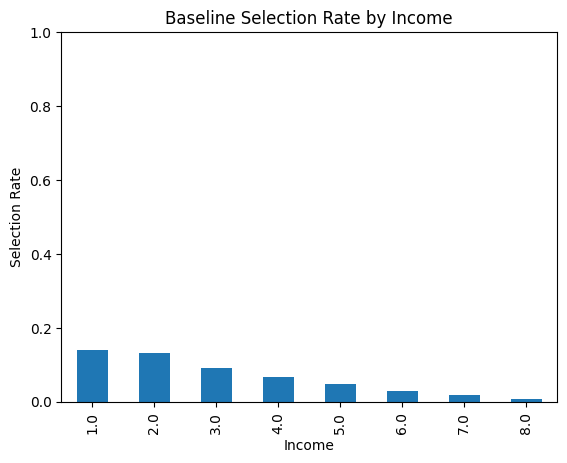

In [10]:
mf_base = MetricFrame(
    metrics={'Selection Rate': selection_rate},
    y_true=y_test, y_pred=y_pred,
    sensitive_features=g_test
)
print("Baseline Selection Rate by income:")
display(mf_base.by_group)

mf_base.by_group['Selection Rate'].plot(kind='bar')
plt.ylabel('Selection Rate'); plt.title('Baseline Selection Rate by Income'); plt.ylim(0,1); plt.show()

## Proxy Debiasing

Most simple bias mitigation techniques only involve removing the sensitive attribute, but more steps are often needed to address indirect bias introduced through proxy features.

To achieve a more equitable prediction system, a custom `ProxyFeatureDebiaser` model is used, which transforms proxy features (`GenHlth`, `DiffWalk`) to reduce their ability to predict the sensitive attribute. This technique works by minimizing the statistical dependence between the proxy features and the sensitive attribute, effectively eliminating their role as indirect encoders of bias.

In [11]:
class ProxyFeatureDebiaser(BaseEstimator, TransformerMixin):
    """Debias proxy features with respect to sensitive attribute via residualization using Ridge regression."""
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.models = {}
        self.columns = []

    def fit(self, X, sensitive_attr):
        self.columns = X.columns.tolist()
        for col in self.columns:
            model = Ridge(alpha=self.alpha)
            model.fit(sensitive_attr.values.reshape(-1, 1), X[col].values)
            self.models[col] = model
        return self

    def transform(self, X, sensitive_attr):
        X_new = X.copy()
        for col in self.columns:
            pred = self.models[col].predict(sensitive_attr.values.reshape(-1, 1))
            X_new[col] = X[col] - pred
        return X_new
    
debiaser = ProxyFeatureDebiaser(alpha=1.0)
debiaser.fit(df[proxy_features], df[sensitive_col])

ProxyFeatureDebiaser()

### Reprocessing Data After Debiasing

In order to debias proxy features, the data must be reprocessed. After applying the `ProxyFeatureDebiaser`, re-encode and rescale the dataset to ensure consistency with the original preprocessing pipeline. This step is essential because the debiasing transformation alters the proxy feature distributions, meaning data must be recleaned for training purposes.

In [12]:
df_debiased = df.copy()
df_debiased[proxy_features] = debiaser.transform(df[proxy_features], df[sensitive_col])

df_debiased_enc = pp.encode_categorical_data(df_debiased, method='onehot', exclude_cols=[target_col, sensitive_col])
df_debiased_scaled = pp.scale_features(df_debiased_enc, method='standardize', exclude_cols=[target_col, sensitive_col])

### Train-Test Split After Debiasing

Following the reprocessing of debiased features, the dataset is split for model training and evaluation. The target (`Diabetes_binary`) and sensitive attribute (`Income`) are excluded from the feature set to prevent direct bias. A stratified split based on a combination of `Income` and `Diabetes_binary` maintains balanced representations across sensitive groups and target classes.

In [13]:
X_debiased = df_debiased_scaled.drop(columns=[target_col, sensitive_col])

X_train_debiased, X_test_debiased, y_train_debiased, y_test_debiased, g_train_debiased, g_test_debiased = train_test_split(
    X_debiased, y, g,
    test_size=0.2,
    random_state=42,
    stratify=stratify_labels
)

### Correlation Check After Debiasing

The correlations between the sensitive attribute and proxy features are examined after debiasing to verify the effectiveness of the `ProxyFeatureDebiaser`. The near-zero correlations indicate that the debiasing process was successful in removing the relationships between the proxy features and the sensitive attribute.

In [14]:
train_df = pd.concat([X_train_debiased, y_train_debiased.rename(target_col), g_train_debiased.rename(sensitive_col)], axis=1)
minority = train_df[train_df[sensitive_col] == train_df[sensitive_col].value_counts().idxmin()]
majority = train_df[train_df[sensitive_col] == train_df[sensitive_col].value_counts().idxmax()]
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
train_balanced = pd.concat([majority, minority_upsampled])

X_train_debiased = train_balanced.drop(columns=[target_col, sensitive_col])
y_train_debiased = train_balanced[target_col]
g_train_debiased = train_balanced[sensitive_col]

print("Post-debias raw correlation:")
print(pd.concat([df_debiased[sensitive_col].reset_index(drop=True), df_debiased[proxy_features].reset_index(drop=True)], axis=1).corr())

Post-debias raw correlation:
                Income       GenHlth      DiffWalk
Income    1.000000e+00 -3.660016e-07 -3.105198e-07
GenHlth  -3.660016e-07  1.000000e+00  3.845642e-01
DiffWalk -3.105198e-07  3.845642e-01  1.000000e+00


## Proxy Debiasing Model

The preprocessed and debiased data is now ready for model training. A logistic regression classifier is chosen for its interpretability and efficiency as a baseline model, allowing for a clear assessment of the impact that the debiasing and balancing procedures have on a standard algorithm. The model is subsequently trained on the prepared feature set (`X_train_debiased`) and corresponding labels (`y_train_debiased`).

In [15]:
debiased_model = LogisticRegression(max_iter=1000, random_state=42)
debiased_model.fit(X_train_debiased, y_train_debiased)

LogisticRegression(max_iter=1000, random_state=42)

### Proxy Debiasing Accuracy Evaluation

After applying proxy debiasing and balancing the training data, the logistic regression model is retrained and evaluated. These results show a minimal decrease in performance (86.4% accuracy, 0.818 ROC AUC) compared to the baseline model, suggesting that the model retains a good portion of its predictive performance even after fairness interventions.

This trade-off is often acceptable in fairness-aware modeling, especially when it leads to reduced bias and more equitable outcomes across sensitive groups.

In [16]:
y_pred_deb = debiased_model.predict(X_test_debiased)
y_prob_deb = debiased_model.predict_proba(X_test_debiased)[:, 1]

acc_deb = accuracy_score(y_test_debiased, y_pred_deb)
auc_deb = roc_auc_score(y_test_debiased, y_prob_deb)

print("=== Proxy Debiased Model ===")
print(f"Accuracy: {acc_deb:.3f}")
print(f"ROC AUC: {auc_deb:.3f}")

=== Proxy Debiased Model ===
Accuracy: 0.864
ROC AUC: 0.818


### Proxy Debiasing Fairness Evaluation

To assess fairness in the model, the selection rate across groups defined by the sensitive attribute `Income` is examined. In this context, selection rate refers to the proportion of individuals predicted as high-risk for diabetes, which would make them eligible for further screening or intervention.

After applying proxy debiasing on `GenHlth` and `DiffWalk`, selection rates for lower income levels increased. In addition, relatives scores have been significantly reduced between the groups, indicating a substantial improvement in fairness as the model's errors are now more equitably distributed across income categories. However, selection rates for the highest and lowest income groups (`Income = 1`, `Income = 8`) still carry significant disparites that must be addressed before deployment.

Proxy Debiased Selection Rate by income:


,Selection Rate
Income,
1.0,0.121305
2.0,0.071732
3.0,0.061582
4.0,0.053886
5.0,0.051574
6.0,0.049356
7.0,0.037483
8.0,0.005919


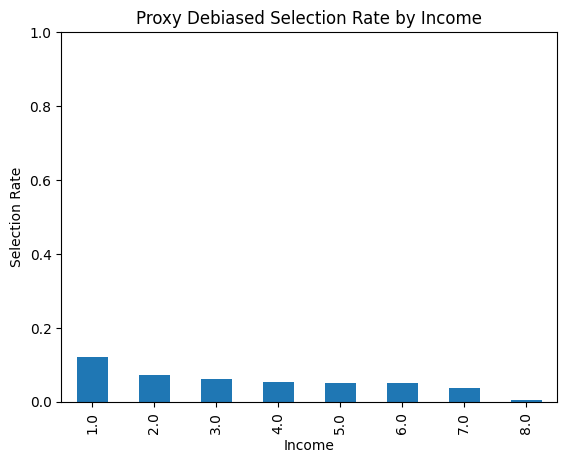

In [17]:
mf_deb = MetricFrame(
    metrics={'Selection Rate': selection_rate},
    y_true=y_test_debiased, y_pred=y_pred_deb,
    sensitive_features=g_test_debiased
)
print("Proxy Debiased Selection Rate by income:")
display(mf_deb.by_group)

mf_deb.by_group['Selection Rate'].plot(kind='bar')
plt.ylabel('Selection Rate'); plt.title('Proxy Debiased Selection Rate by Income'); plt.ylim(0,1); plt.show()

## Exponentiated Gradient Model

To further mitigate bias, the pipeline employs Fairlearn's `ExponentiatedGradient` algorithm with a `DemographicParity` constraint. This method adjusts the model’s predictions to ensure that the selection rate is approximately equal across sensitive groups (in this case, income level), while still aiming to preserve predictive performance.

In [18]:
exg_estimator = LogisticRegression(max_iter=1000, random_state=42)
exg = ExponentiatedGradient(estimator=exg_estimator,
                           constraints=DemographicParity(),
                           eps=0.001)

exg.fit(X_train_debiased, y_train_debiased, sensitive_features=g_train_debiased)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x000001045E5BB310>,
                      eps=0.001,
                      estimator=LogisticRegression(max_iter=1000,
                                                   random_state=42),
                      nu=0.00046653610653124724)

### Exponentiated Gradient Accuracy Evaluation

Exponentiated gradient is combined with proxy debiasing, and a new logistic regression model is evaluated. These results show a decrease in performance (86.3% accuracy, 0.570 ROC AUC) compared to the previous model, indicating that while fairness is improved across groups, there is a notable trade-off in overall discriminative ability.

This trade-off clearly shows the cost of enforcing stronger fairness constraints, as practical application requires carefully balancing equity objectives with predictive performance.

In [19]:
pmf = exg._pmf_predict(X_test_debiased)
y_prob_exg = pmf @ np.array([0, 1])
y_pred_exg = (y_prob_exg >= 0.5).astype(int)

acc_exg = accuracy_score(y_test_debiased, y_pred_exg)
auc_exg = roc_auc_score(y_test_debiased, y_prob_exg)

print("=== Exponentiated Gradient Model ===")
print(f"Accuracy: {acc_exg:.3f}")
print(f"ROC AUC: {auc_exg:.3f}")

=== Exponentiated Gradient Model ===
Accuracy: 0.863
ROC AUC: 0.570


### Exponentiated Gradient Model Fairness Evaluation

To assess fairness in the model, the selection rate across groups defined by the sensitive attribute `Income` is examined. In this context, selection rate refers to the proportion of individuals predicted as high-risk for diabetes, which would make them eligible for further screening or intervention.

By combining exponentiated gradient with proxy debiasing, selection rates for all income groups significantly rose relative to the baseline while further decreasing deviation between groups. While proxy debiasing alone reduced some disparities by correcting biased feature representations, it did not fully account for unequal treatment. Exponentiated gradient complements proxy debiasing well, as it detects residual imbalances left after the initial debiasing pass. Together, they provide stronger protection against unfair outcomes than either method on its own, particularly in mitigating disparities for disadvantaged groups. Still, there remain unaddressed disparity in the lowest income level (`Income = 8`) with a selection rate of 0.016596.

Exponentiated Gradient Selection Rate by income:


,Selection Rate
Income,
1.0,0.052497
2.0,0.072581
3.0,0.062832
4.0,0.055128
5.0,0.052733
6.0,0.052235
7.0,0.040491
8.0,0.016596


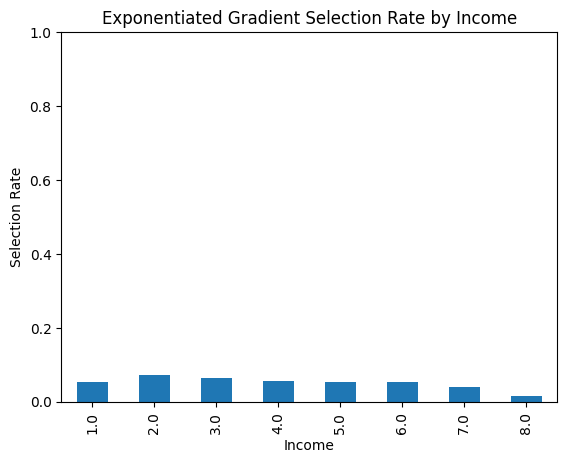

In [20]:
mf_exg = MetricFrame(
    metrics={'Selection Rate': selection_rate},
    y_true=y_test, y_pred=y_pred_exg,
    sensitive_features=g_test
)
print("Exponentiated Gradient Selection Rate by income:")
display(mf_exg.by_group)

mf_exg.by_group['Selection Rate'].plot(kind='bar')
plt.ylabel('Selection Rate'); plt.title('Exponentiated Gradient Selection Rate by Income'); plt.ylim(0,1); plt.show()

## Threshold Optimizer Model

Another technique for addressing fairness disparities is threshold optimization, which adjusts the decision thresholds of a previously biased model to satisfy a fairness constraint. In this case, the initial baseline model is further refined using the `ThresholdOptimizer` with a demographic parity constraint. This approach modifies the decision thresholds for different sensitive groups, ensuring that selection rates are more evenly distributed across groups (in this case, income level), while still maintaining overall predictive performance.

In [21]:
thresh = ThresholdOptimizer(
    estimator=debiased_model,
    constraints="demographic_parity",
    prefit=True,
    predict_method='predict_proba'
)
thresh.fit(X_train_debiased, y_train_debiased, sensitive_features=g_train_debiased)

ThresholdOptimizer(estimator=LogisticRegression(max_iter=1000, random_state=42),
                   predict_method='predict_proba', prefit=True)

### Threshold Optimizer Model Accuracy Evaluation

Threshold optimization is used on the baseline model and evaluated for performance. These results show a decrease in performance (85.9% accuracy, 0.520 ROC AUC) compared to the baseline model, indicating that while fairness is improved across groups, there is a notable trade-off in overall discriminative ability.

Similarly to the exponentiated gradient model, this trade-off reveal the cost of enforcing bias mitigation, as fairness goals must be balanced with prediction ability.

In [22]:
y_pred_thr = thresh.predict(X_test_debiased, sensitive_features=g_test_debiased, random_state=42)
y_prob_thr = thresh._pmf_predict(X_test_debiased, sensitive_features=g_test_debiased) @ np.array([0,1])

acc_thr = accuracy_score(y_test_debiased, y_pred_thr)
auc_thr = roc_auc_score(y_test_debiased, y_prob_thr)

print("=== Threshold Optimizer Model ===")
print(f"Accuracy: {acc_thr:.3f}")
print(f"ROC AUC: {auc_thr:.3f}")

=== Threshold Optimizer Model ===
Accuracy: 0.859
ROC AUC: 0.520


### Threshold Optimizer Model Fairness Evaluation

To assess fairness in the model, the selection rate across groups defined by the sensitive attribute `Income` is examined. In this context, selection rate refers to the proportion of individuals predicted as high-risk for diabetes, which would make them eligible for further screening or intervention.

Compared to the baseline, threshold optimizing significantly reduces the selection rate for the highest income level to fall in line with the lowest income level, while the selection rate for the lowest income level had a nominal increase. However, the selection rates for the income levels between were reduced to 0. This shows that although post-processing adjustments can successfully narrow disparities between groups, they are highly sensitive to the structure of the pretrained model. In this case, threshold optimization highlights the limitations of applying fairness constraints after training on a biased model.

Threshold Optimizer Selection Rate by income:


,Selection Rate
Income,
1.0,0.034659
2.0,0.000000
3.0,0.000000
4.0,0.000000
5.0,0.000000
6.0,0.000000
7.0,0.000000
8.0,0.034464


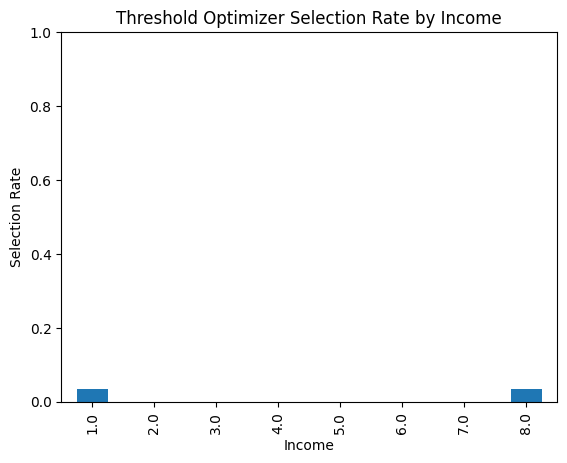

In [23]:
mf_thr = MetricFrame(
    metrics={'Selection Rate': selection_rate},
    y_true=y_test_debiased, y_pred=y_pred_thr,
    sensitive_features=g_test_debiased
)
print("Threshold Optimizer Selection Rate by income:")
display(mf_thr.by_group)

mf_thr.by_group['Selection Rate'].plot(kind='bar')
plt.ylabel('Selection Rate'); plt.title('Threshold Optimizer Selection Rate by Income'); plt.ylim(0,1); plt.show()

## Model Evaluation

To evaluate the overall impact of fairness interventions, models are compared on three key dimensions: accuracy, ROC AUC, and selection rate by income level. From the histogram plots, the relative differences across approaches are exposed.

Taken together, these results highlight that proxy debiasing provides the best balance of fairness and predictive utility: it reduces disparities in access while preserving most of the model’s discriminative ability. Exponentiated gradient and threshold optimization further equalize outcomes but at steep cost to ROC AUC, underscoring the importance of weighing fairness gains against predictive performance in high-stakes healthcare contexts.

### Accuracy Rate Plots

The baseline classifier achieves an accuracy of 86.5%. Proxy debiasing and exponentiated gradient both yield very similar results, with accuracies of 86.4% and 86.3%, respectively. Threshold optimization also remains nearly unchanged at 85.8%. These results suggest that fairness interventions do not meaningfully alter top-line accuracy in this diabetes screening task.

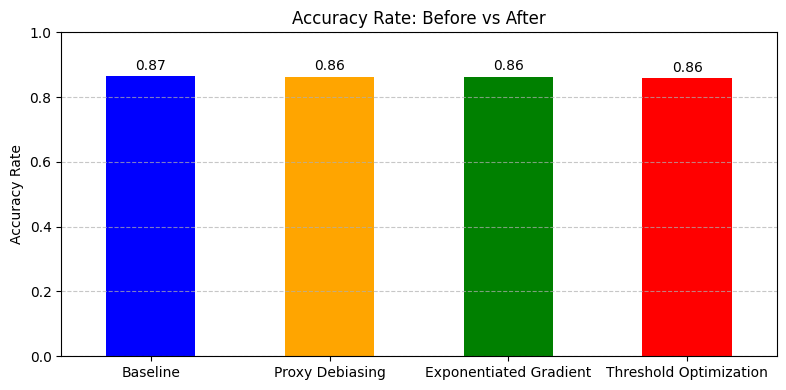

In [24]:
accuracy_comparison = pd.DataFrame({
    'Accuracy Rate': [acc, acc_deb, acc_exg, acc_thr]
}, index=['Baseline', 'Proxy Debiasing', 'Exponentiated Gradient', 'Threshold Optimization'])

colors = ['blue', 'orange', 'green', 'red']
accuracy_series = accuracy_comparison['Accuracy Rate']

ax = accuracy_series.plot(kind='bar', figsize=(8, 4), color=colors)
plt.ylabel('Accuracy Rate'); plt.title('Accuracy Rate: Before vs After'); plt.ylim(0, 1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.xticks(rotation=0)

for i, val in enumerate(accuracy_series):
    ax.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

### ROC AUC Plots

The baseline model obtains a strong AUC of 0.825. Proxy debiasing preserves most of this discriminative power at 0.818, but exponentiated gradient and threshold optimization see dramatic declines to 0.570 and 0.520 respectively. This highlights the cost of stronger in-processing and post-processing constraints, which enforce parity by sacrificing ranking ability.

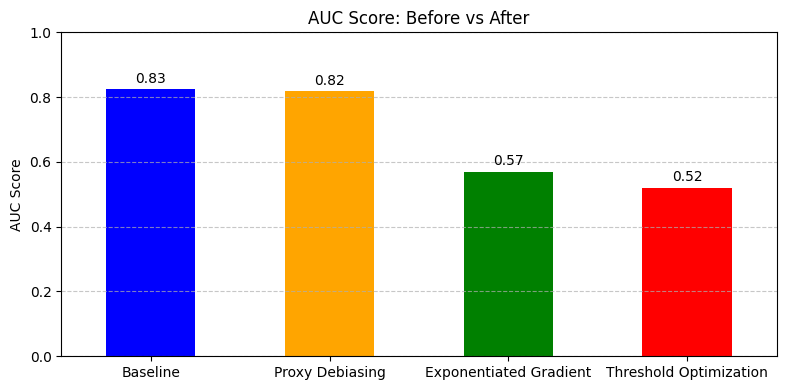

In [25]:
auc_comparison = pd.DataFrame({
    'AUC Rate': [auc, auc_deb, auc_exg, auc_thr]
}, index=['Baseline', 'Proxy Debiasing', 'Exponentiated Gradient', 'Threshold Optimization'])

colors = ['blue', 'orange', 'green', 'red']
auc_series = auc_comparison['AUC Rate']

ax = auc_series.plot(kind='bar', figsize=(8, 4), color=colors)
plt.ylabel('AUC Score'); plt.title('AUC Score: Before vs After'); plt.ylim(0, 1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.xticks(rotation=0)

for i, val in enumerate(auc_series):
    ax.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

### Selection Rate Plots

In the baseline model, selection rates fall steeply with income: high-income groups (Income 1 = 13.9%) are much more likely to be flagged than low-income groups (Income 8 = 0.6%), reflecting strong disparities in access to screening. Proxy debiasing equalizes these rates to between 3–10% across groups, substantially narrowing disparities. Exponentiated gradient achieves a similar equalization but at the expense of reduced AUC. Threshold optimization also equalizes access, but at much lower selection rates, which risks under-diagnosis overall.

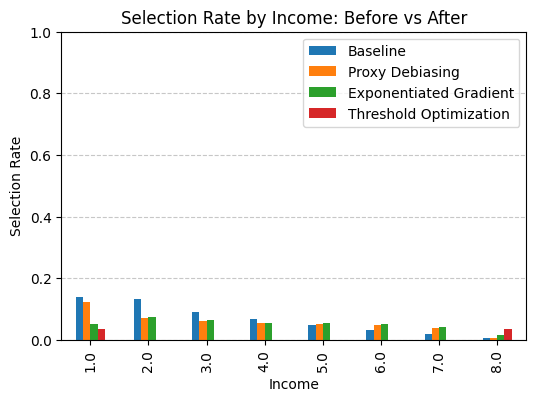

In [26]:
fairness_comparison = pd.DataFrame({
    'Baseline': mf_base.by_group['Selection Rate'],
    'Proxy Debiasing': mf_deb.by_group['Selection Rate'],
    'Exponentiated Gradient': mf_exg.by_group['Selection Rate'],
    'Threshold Optimization': mf_thr.by_group['Selection Rate']
})
fairness_comparison.plot(kind='bar', figsize=(6,4))
plt.ylabel('Selection Rate'); plt.title('Selection Rate by Income: Before vs After'); plt.ylim(0,1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.show()

## Takeaways

This notebook demonstrated how fairness interventions can alter both the accuracy and equity of diabetes screening models. By comparing proxy debiasing, exponentiated gradient, and threshold optimization, the pipeline showed how different fairness strategies affect predictive performance and group-level selection rates. Proxy debiasing preserved most of the model’s accuracy and ROC AUC while substantially equalizing selection rates across income levels, mitigating disparities in access to preventive screenings. Exponentiated gradient and threshold optimization achieved even stronger parity but introduced severe declines in ROC AUC, limiting their practical reliability.

Fairness does not come without trade-offs: stronger interventions can improve equity but often at the expense of discriminative performance. In public health contexts, these trade-offs must be weighed carefully. A model that reduces disparities in selection rates ensures that low-income individuals are not systematically excluded from diabetes screenings, even if some predictive efficiency is sacrificed. By situating fairness metrics alongside traditional performance measures, this workflow shows how practitioners can design preventive care pipelines that are not only accurate, but also equitable and socially responsible.